In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

#使用GPU
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# LSTM-CNN并联结构

In [1]:
%%html
<img src='1.jpg', width=80%>

# LSTM-CNN并联结构
![avatar](2.jpg)

我们采用的是一维卷积conv1d：
class torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

1. in_channels(int) – 输入信号的通道。
2. out_channels(int) – 卷积产生的通道。有多少个out_channels，就需要多少个1维卷积
3. kernel_size(int or tuple) - 卷积核的尺寸，卷积核的大小为(k,)，第二个维度是由in_channels来决定的，所以实际上卷积大小为kernel_size*in_channels
4. stride(int or tuple, optional) - 卷积步长
5. padding (int or tuple, optional)- 输入的每一条边补充0的层数
6. dilation(int or tuple, `optional``) – 卷积核元素之间的间距
7. groups(int, optional) – 从输入通道到输出通道的阻塞连接数
8. bias(bool, optional) - 如果bias=True，添加偏置

举个例子：

In [10]:
conv1 = nn.Conv1d(in_channels=256,out_channels=100,kernel_size=2)
Input = torch.randn(32,35,256)
# batch_size x len x in_channels -> batch_size x in_channels x len
Input = Input.permute(0,2,1)
out = conv1(Input)# batch_size x out_channels x len
print(out.size())

torch.Size([32, 100, 34])


In [11]:
Input.size()

torch.Size([32, 256, 35])

In [15]:
layer1 = nn.Sequential(
            nn.Conv1d(256, 100, 2), 
            nn.BatchNorm1d(100),
            nn.ReLU(True),
        )

In [18]:
layer2 = nn.Sequential(
            nn.Conv1d(100, 200, 2), 
            nn.BatchNorm1d(200),
            nn.ReLU(True),
            nn.MaxPool1d(2),
        )

In [16]:
output = layer1(Input)
output.size()

torch.Size([32, 100, 34])

In [19]:
output = layer2(output)
output.size()#batch_size x out_channels x len

torch.Size([32, 200, 16])

In [28]:
output[0]

tensor([[0.0000, 0.3177, 2.1707,  ..., 1.5071, 2.4608, 1.1833],
        [0.8323, 1.3476, 0.4405,  ..., 0.0000, 0.6498, 0.9868],
        [1.7601, 0.1389, 0.7517,  ..., 0.9630, 0.6334, 1.7470],
        ...,
        [0.2442, 0.0000, 0.3076,  ..., 0.0000, 1.1275, 0.3061],
        [0.2264, 0.7633, 1.0636,  ..., 1.1116, 0.3339, 0.2534],
        [0.0000, 2.6330, 0.6691,  ..., 0.0031, 0.7187, 1.0417]],
       grad_fn=<SelectBackward>)

In [22]:
out_reshape = output.reshape([16,32,200])
out_reshape.size()

torch.Size([16, 32, 200])

In [26]:
out_reshape[0]

tensor([[0.0000e+00, 3.1772e-01, 2.1707e+00,  ..., 3.9868e-01, 5.2411e-01,
         1.9799e-01],
        [0.0000e+00, 0.0000e+00, 1.3518e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.4752e-01],
        [0.0000e+00, 1.5264e+00, 1.2447e+00,  ..., 4.7978e-01, 7.8654e-01,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.1298e+00, 0.0000e+00,  ..., 0.0000e+00, 7.3621e-01,
         1.7101e+00],
        [7.8483e-01, 7.6914e-01, 1.0571e+00,  ..., 0.0000e+00, 5.2382e-01,
         1.7580e-01],
        [3.2530e-04, 7.6892e-01, 2.5264e-01,  ..., 6.8710e-01, 1.8343e+00,
         0.0000e+00]], grad_fn=<SelectBackward>)

In [29]:
out_re = output.permute(2,0,1)
out_re.size()

torch.Size([16, 32, 200])

In [30]:
out_re[0]

tensor([[0.0000, 0.8323, 1.7601,  ..., 0.2442, 0.2264, 0.0000],
        [1.0202, 0.8127, 0.0000,  ..., 0.0000, 0.0000, 0.3942],
        [1.4420, 0.4491, 0.0000,  ..., 0.4099, 1.3345, 0.0000],
        ...,
        [0.2269, 0.0000, 0.0000,  ..., 0.0904, 0.3066, 0.5451],
        [0.2025, 0.9692, 0.9243,  ..., 1.2320, 0.3726, 0.0000],
        [0.1609, 0.7855, 0.5160,  ..., 0.0000, 0.2664, 0.3822]],
       grad_fn=<SelectBackward>)

In [21]:
result = output.view(output.size(0),-1)
result.size()[1]

3200

## 一些辅助函数，比如说用于可视化损失的函数等

In [ ]:
# 开始训练

# “tearcher_forcing_ratio将上一时刻的真实目标输出当作下一个时刻的Encoder网络的输入，而不是使用Encoder网络的上一时刻的预测输出作为下一时刻的输入。
tearcher_forcing_ratio = 0.5  

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    # encoder部分
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # decoder部分
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_foring = True if random.random() < tearcher_forcing_ratio else False
    
    # using teacher forcing
    if use_teacher_foring:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  
            
    # 不使用teacher forcing,使用上一时刻的输出作为下一时刻的输入        
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  
            
            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length


# 辅助函数------记录时间

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))


# 整个训练过程如下：
 # 开启定时器
 # 初始化优化器和loss函数
 # 创建training pairs
 # 开始训练并绘图

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()  # 开启定时器
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)  # 定义优化算法
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))  # 创建training pairs
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()  # 定义损失函数

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


# 绘制loss曲线

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


# 测试阶段--------测试阶段整体与训练阶段类似，但是测试阶段，不用给出target_tensor,只是将decoder网络上一时刻的预测值作为下一时刻的输入值
# 当预测值是EOS时，则停止预测

def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
     with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # encoder部分
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        # decoder部分
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:  # 结束时的条件
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

# 随机地从训练集中选择pairs,然后在测试集上进行评估

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('输入:>', pair[0])
        print('目标:=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('预测:<', output_sentence)
        print('')

# 正式训练开始运行

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

evaluateRandomly(encoder1, attn_decoder1)

# 注意力可视化

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy());

# 增加坐标轴，更加清楚的可视化

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

# CNN预测
我们采用两层CNN

In [2]:
class cnn(nn.Module):
    def __init__(self,in_channel,out_channel,kernel_size):
        """
        初始化参数：
        in_channel:输入信号通道数
        out_channel:输出信号通道数
        kernel_size:卷积核的尺寸
        """
        super(cnn,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channel, out_channel, kernel_size), 
            nn.BatchNorm1d(out_channel),
            nn.ReLU(True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(out_channel, out_channel * 2, kernel_size), 
            nn.BatchNorm1d(out_channel * 2),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size),
        )
        
    def forward(self,x):
        """
        输入数据x维度：(batch_size x len x in_channel)
        """
        x = x.permute(0,2,1) # (batch_size x in_channel x len)
        x = self.layer1(x) # batch_size x out_channel x (len - kernel_size)
        x = self.layer2(x) # batch_size x out_channel*2 x len 2
        x = x.view(x.size(0),-1) #(batch_size,out_channel*2 x len 2)
        feature_size = x.size()[1]
        
        # MLP
        fc = nn.Sequential(
            nn.Linear(feature_size,1024),
            nn.ReLU (inplace=True),
            nn.Linear(1024,128),
            nn.ReLU (inplace=True),
            nn.Linear(128,2),
        )
        y = fc(x) #(batch_size,1)
        return y

# LSTM的网络结构
![avatar](3.png)

pytorch中LSTM的用法：

调用的函数为nn.LSTM(input_size,hidden_size,layer_nums,bias,batch_first,dropout,bidirectional)

参数介绍：

1. input_size： 输入数据X的特征值的数目。
2. hidden_size： 隐藏层的神经元数量， 也就是隐藏层的特征数量。
3. num_layers： 循环神经网络的层数， 默认值是 2
4. bias： 默认为 True， 如果为 false 则表示神经元不使用 bias 偏移参数。
5. batch_first： 如果设置为 True， 则输入数据的维度中第一个维度就是 batch 值， 默认为 False。 默认情况下第一个维度是序列的长度，第二个维度才是 batch， 第三个维度是特征数目。
6. dropout： 如果不为空， 则表示最后跟一个 dropout 层抛弃部分数据， 抛弃数据的比例由该参数指定
7. bidirectional ： 布尔型， 设置为 True 那么 LSTM 就是一个双向的RNN 网络（双向是指同时可以往后影响参数） ， 默认是 False

举例来说明一下：

In [2]:
from torch.autograd import Variable
rnn = nn.LSTM(10, 20, 2)
Input = Variable(torch.randn(5, 3, 10))#Input的维度：(seq_len, batch, input_size)
h0 = Variable(torch.randn(2, 3, 20)) #初始化h0 维度：(layer_nums, batch, output_size)
c0 = Variable(torch.randn(2, 3, 20))#初始化c0 维度：(layer_nums, batch, output_size)
output, hn = rnn(Input, (h0, c0))

In [4]:
output.size()  # 维度：(seq_len, batch, output_size)

torch.Size([5, 3, 20])

In [3]:
output[0]

tensor([[ 0.1570,  0.0959,  0.2414,  0.2430, -0.3435, -0.1865,  0.2422,  0.0560,
          0.2928,  0.2439,  0.5165,  0.0623, -0.1953,  0.3017, -0.0910,  0.2352,
         -0.3289,  0.0386,  0.2155,  0.1502],
        [ 0.0058,  0.4965,  0.2025,  0.0409, -0.0615,  0.0253, -0.2841, -0.3032,
         -0.2337, -0.3089, -0.0261,  0.1096, -0.0379,  0.1132, -0.3785, -0.2796,
         -0.1697,  0.1210,  0.1051, -0.0469],
        [-0.0547, -0.4129,  0.6197,  0.3115, -0.2762, -0.2373,  0.0167, -0.3734,
         -0.1518,  0.0341, -0.0078, -0.1033, -0.3177, -0.2452,  0.3524, -0.2154,
          0.2136, -0.0500,  0.1895,  0.1901]], grad_fn=<SelectBackward>)

In [11]:
output[2]

tensor([[ 0.1066,  0.0041,  0.1111,  0.1036, -0.2901, -0.0749,  0.1506,  0.0692,
         -0.0334,  0.2276,  0.2394,  0.1446,  0.0251, -0.0696, -0.0262, -0.0104,
         -0.0652,  0.0286,  0.2289, -0.0211],
        [ 0.0614,  0.0733,  0.0152,  0.0311, -0.0711, -0.0009, -0.1400, -0.0729,
         -0.1489,  0.0454,  0.0489,  0.1252,  0.0521, -0.0520, -0.1389, -0.2169,
         -0.0551, -0.0149,  0.1160, -0.0560],
        [ 0.0300, -0.1165,  0.1703,  0.1384, -0.1117, -0.1159, -0.0034, -0.1029,
         -0.1349,  0.1650,  0.0608,  0.0533, -0.0505, -0.0630,  0.1866, -0.0631,
          0.0345, -0.1173,  0.1396,  0.0234]], grad_fn=<SelectBackward>)

In [5]:
out = output.permute(1,0,2)
out[0]

tensor([[ 1.5698e-01,  9.5949e-02,  2.4141e-01,  2.4304e-01, -3.4348e-01,
         -1.8650e-01,  2.4222e-01,  5.6042e-02,  2.9282e-01,  2.4386e-01,
          5.1655e-01,  6.2313e-02, -1.9530e-01,  3.0175e-01, -9.1013e-02,
          2.3515e-01, -3.2894e-01,  3.8633e-02,  2.1549e-01,  1.5024e-01],
        [ 9.9016e-02,  6.0166e-02,  1.7484e-01,  1.6330e-01, -3.4359e-01,
         -1.0986e-01,  2.1830e-01,  7.9328e-02,  1.2120e-01,  2.1359e-01,
          3.1021e-01,  1.2297e-01, -3.8226e-02,  4.8337e-02, -7.8538e-02,
          5.3963e-02, -1.6336e-01,  6.7736e-02,  2.3542e-01,  1.7723e-02],
        [ 1.0655e-01,  4.1368e-03,  1.1108e-01,  1.0363e-01, -2.9008e-01,
         -7.4919e-02,  1.5063e-01,  6.9218e-02, -3.3385e-02,  2.2758e-01,
          2.3938e-01,  1.4464e-01,  2.5068e-02, -6.9611e-02, -2.6183e-02,
         -1.0438e-02, -6.5240e-02,  2.8590e-02,  2.2889e-01, -2.1124e-02],
        [ 1.1184e-01, -4.4089e-02,  4.3908e-02,  6.7496e-02, -2.1142e-01,
         -4.4925e-02,  9.5251e-02, 

In [13]:
out.size()

torch.Size([3, 5, 20])

In [15]:
o = out.reshape(3,5*20)
o[0]

tensor([ 1.5698e-01,  9.5949e-02,  2.4141e-01,  2.4304e-01, -3.4348e-01,
        -1.8650e-01,  2.4222e-01,  5.6042e-02,  2.9282e-01,  2.4386e-01,
         5.1655e-01,  6.2313e-02, -1.9530e-01,  3.0175e-01, -9.1013e-02,
         2.3515e-01, -3.2894e-01,  3.8633e-02,  2.1549e-01,  1.5024e-01,
         9.9016e-02,  6.0166e-02,  1.7484e-01,  1.6330e-01, -3.4359e-01,
        -1.0986e-01,  2.1830e-01,  7.9328e-02,  1.2120e-01,  2.1359e-01,
         3.1021e-01,  1.2297e-01, -3.8226e-02,  4.8337e-02, -7.8538e-02,
         5.3963e-02, -1.6336e-01,  6.7736e-02,  2.3542e-01,  1.7723e-02,
         1.0655e-01,  4.1368e-03,  1.1108e-01,  1.0363e-01, -2.9008e-01,
        -7.4919e-02,  1.5063e-01,  6.9218e-02, -3.3385e-02,  2.2758e-01,
         2.3938e-01,  1.4464e-01,  2.5068e-02, -6.9611e-02, -2.6183e-02,
        -1.0438e-02, -6.5240e-02,  2.8590e-02,  2.2889e-01, -2.1124e-02,
         1.1184e-01, -4.4089e-02,  4.3908e-02,  6.7496e-02, -2.1142e-01,
        -4.4925e-02,  9.5251e-02,  6.6789e-02, -9.9

In [11]:
len(hn) # 包含两个值，一个为h，一个是c

2

In [12]:
hn[0].size() # 维度：(layer_nums, batch, output_size)是最后的输出状态

torch.Size([2, 3, 20])

In [13]:
hn[1].size() # 维度：(layer_nums, batch, output_size)是最后的输出状态

torch.Size([2, 3, 20])

# LSTM各门控单元原理

![avatar](4.png)

输入门：\begin{equation}
f_{t}=\sigma\left(W_{h f} h_{t-1}+W_{x f} x_{t}+b_{f}\right)
\end{equation}

![avatar](5.png)

遗忘门：
\begin{equation}
i_{t}=\sigma\left(W_{h i} h_{t-1}+W_{x i} x_{t}+b_{i}\right)
\end{equation}

更新cell状态：
\begin{equation}
\widetilde{C}_{t}=\tanh \left(W_{h c} h_{t-1}+W_{x c} x_{t}+b_{c}\right)
\end{equation}

![avatar](6.png)

最终cell状态：
\begin{equation}
C_{t}=f_{t} \times C_{t-1}+i_{t} \times \widetilde{C}_{t}
\end{equation}

![avatar](7.png)

输出门：
\begin{equation}
o_{t}=\sigma\left(W_{h o} h_{t-1}+W_{x 0} x_{t}+b_{o}\right)
\end{equation}

隐藏层：
\begin{equation}
h_{t}=o_{t} \times \tanh \left(C_{t}\right)
\end{equation}

由上面，可知h,b和C均为output_size的向量，与h相对应的W是(output_size,output_size)的矩阵，而与x相对应的W是(output_size,input_size)的矩阵。

In [46]:
type(rnn.all_weights)

list

In [26]:
gru = nn.GRU(10,20,6)
Input = Variable(torch.randn(5, 4, 10))#Input的维度：(seq_len, batch, input_size)
h0 = Variable(torch.randn(6, 4, 20)) #初始化h0 维度：(layer_nums, batch, output_size)
out,h = gru(Input, h0)

In [27]:
out.size() # 维度：(seq_len, batch, output_size)

torch.Size([5, 4, 20])

In [28]:
h.size() # 维度：(layer_nums, batch, output_size)

torch.Size([6, 4, 20])

In [3]:
class lstm(nn.Module):
    def __init__(self,input_size,hidden_size,lstm_layers,output_size=2,dropout=0.1):
        super(lstm, self).__init__()
        self.input_size = input_size #输入层的特征值的数目
        self.hidden_size = hidden_size #隐藏层的神经元数量
        self.lstm_layers = lstm_layers #LSTM层数
        self.dropout = dropout #dropout率
        self.output_size = output_size
        self.layer = nn.LSTM(input_size,hidden_size,lstm_layers,dropout=dropout)
    def forward(self, x):
        """
        输入数据x的维度：(batch,seq,input_size)
        """
        x = x.permute(1,0,2) #(seq,batch,input_size)
        x,_ = self.layer(x) #seq,batch,hidden
        s,b,h = x.size()
        x = x.permute(1,0,2) #batch,seq,hidden
        x = x.reshape(b,s*h) #batch,seq*hidden
        
        # MLP
        fc = nn.Sequential(
            nn.Linear(s*h,1024),
            nn.ReLU (inplace=True),
            nn.Linear(1024,128),
            nn.ReLU (inplace=True),
            nn.Linear(128,self.output_size),
        )
        y = fc(x)
        return y

# LSTM-CNN并联结构

In [4]:
class lstm_cnn_parallel(nn.Module):
    def __init__(self,in_channel, out_channel,hidden_size,kernel_size,lstm_layers=2,dropout=0.1):
        """
        初始化args:
        in_channel:cnn输入信号通道数，也是lstm的input_size
        out_channel:cnn输出信号通道数
        hidden_size:lstm输出
        kernel_size:cnn卷积核的尺寸
        lstm_layer:lstm层数
        dropout
        """
        super(lstm_cnn_parallel, self).__init__()
        self.in_channel = in_channel #输入层的特征值的数目
        self.out_channel = out_channel #隐藏层的神经元数量
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers #LSTM层
        self.lstm = nn.LSTM(in_channel,hidden_size,lstm_layers,dropout=dropout)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channel, out_channel, kernel_size), 
            nn.BatchNorm1d(out_channel),
            nn.ReLU(True),
            nn.Conv1d(out_channel, out_channel * 2, kernel_size), 
            nn.BatchNorm1d(out_channel * 2),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size),
        )
    def forward(self, x):
        """
        前向传播，x为输入张量，形状为(batch,seq,input_size)
        """
        y1,_ = self.lstm(x.permute(1,0,2)) #y1:(seq,batch,hidden)
        y2 = self.cnn(x.permute(0,2,1)) # y2:(batch_size x out_channel*2 x len 2)
        
        #将y1和y2转化成(batch,*)的张量
        y2 = y2.view(y2.size(0),-1) #(batch_size,out_channel*2 x len 2)
        s,b,h = y1.size()
        y1 = y1.permute(1,0,2) # (batch,seq,hidden)
        y1 = y1.reshape(b,s*h) # (batch,seq*hidden)
        
        #将y1和y2拼接起来
        y =  torch.cat((y1,y2),1) # (batch,out_channel*2 x len 2+seq*hidden)
        feature_size = y.size()[1]
        
        #MLP
        fc = nn.Sequential(
            nn.Linear(feature_size,1024),
            nn.ReLU (inplace=True),
            nn.Linear(1024,128),
            nn.ReLU (inplace=True),
            nn.Linear(128,2),
        )
        y = fc(y) #(batch_size,2)
        return y

# LSTM-CNN串联结构

In [5]:
class lstm_cnn_series(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size,lstm_layers,output_size=2,dropout=0.1):
        """
        初始化args:
        in_channel:cnn输入信号通道数
        out_channel:cnn输出信号通道数
        kernel_size:cnn卷积核的尺寸
        lstm_layer:lstm层数
        """
        super(lstm_cnn_series, self).__init__()
        self.in_channel = in_channel #CNN输入层的特征值的数目
        self.out_channel = out_channel #CNN输出层的神经元数量
        self.kernel_size = kernel_size #卷积核
        self.lstm_layers = lstm_layers #LSTM层
        self.output_size = output_size #最后输出特征
        self.dropout = dropout #最后输出特征
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv1d(in_channel, out_channel, kernel_size), 
            nn.BatchNorm1d(out_channel),
            nn.ReLU(True),
        )
        self.cnn_layer2 = nn.Sequential(
            nn.Conv1d(out_channel, out_channel*2, kernel_size), 
            nn.BatchNorm1d(out_channel*2),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size),
        )
        self.lstm = nn.LSTM(out_channel*2,out_channel*2,lstm_layers,dropout=dropout)
        
        
    def forward(self, x):
        """
        输入数据x维度:(batch_size x len x in_channels)
        """
        # cnn层
        x = self.cnn_layer1(x.permute(0,2,1)) # batch_size x out_channels x len 1
        x = self.cnn_layer2(x) # batch_size x out_channels*2 x len 2
        x = x.permute(2,0,1)   # len 2 x batch_size x out_channels*2
        
        # lstm层
        x,_ = self.lstm(x) # len 2 x batch_size x out_channels*2
        s,b,h = x.size()
        x = x.permute(1,0,2) #batch,seq,hidden
        x = x.reshape(b,s*h) #batch,seq*hidden
        
        #MLP
        fc = nn.Sequential(
            nn.Linear(s*h,1024),
            nn.ReLU (inplace=True),
            nn.Linear(1024,128),
            nn.ReLU (inplace=True),
            nn.Linear(128,self.output_size),
        )
        y = fc(x) #(batch_size,1)
        return y

# 导入数据

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('gemini_BTCUSD_1hr.csv',index_col=[0],usecols=['Date','High','Low','Close','Volume'])
data.head()

,Close,High,Low,Volume
Date,,,,
2015/10/8 13:00,245.00,245.00,0.00,0.606654
2015/10/8 14:00,245.00,245.00,244.50,4.453649
2015/10/8 15:00,244.92,245.00,244.92,3.016926
2015/10/8 16:00,244.25,244.92,244.25,3.895252
2015/10/8 17:00,244.99,244.99,244.02,3.920632


In [5]:
data.iloc[22283]
data = data.iloc[22283:]

Close     9177.880000
High      9211.240000
Low       8925.000000
Volume     791.276838
Name: 2018/4/24 0:00, dtype: float64

# 小波分解去噪重构
小波变换是通过一系列小波函数来对原始信息重新表示。我们假设基小波函数为$\psi$,满足

处理工具：pywt库
## 小波分解
小波分解使用函数pywt.wavedec

该函数需要的参数一般有三个：data，wavelet，level。data为处理的数据，wavelet指的是小波族，一共有后面几种，[‘haar’, ‘db’, ‘sym’, ‘coif’, ‘bior’, ‘rbio’, ‘dmey’]。level指的是分解的阶数，设置为n就返回一个n维的list[cAn, cDn, cDn-1, …, cD2, cD1]，n为分解阶次，cAn是逼近系数数组，后面的依次是细节系数数组。

## 重构
重构使用函数pywt.waverec

该函数需要的参数一般有两个：coeffs和wavelet。其中，coeffs为小波分解并处理后的list。wavelet和函数pywt.wavedec保持一致即可

## 小波去噪
小波去噪使用函数pywt.threshold

该函数需要的参数一般有：数据data，阈值value，模式mode，和替换值substitute

value是用来和data里的数据做比较的。

mode有四种，{‘soft’, ‘hard’, ‘garrote’, ‘greater’, 'less}指的是不同的替换方式。

substitute是用来做替换的值

In [ ]:
w = pywt.Wavelet('db8') # 选用Daubechies8小波
data_denoise = pd.DataFrame(columns=['Close','High','Low','Volume'])
threshold = 0.5 # Threshold for filtering
for i in range(4):
    d = data.iloc[:,i]
    maxlev = pywt.
# Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(da, w, level=maxlev) # 将信号进行小波分解
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) # 将噪声滤波
    datarec = pywt.waverec(coeffs, w)
    data_denoise.iloc[:,i] = datarec

# 数据预处理

In [9]:
#增加移动平均特征
def add_moving_mean(data,feature,window=5):
    """
    该函数可以增加移动平均特征，需要的初始化参数为：
    data：数据源，为DataFrame类型
    feature：特征，表示对该特征做移动平均
    window：移动窗口数
    返回的是一个Series，为feature的移动平均值
    """
    return data[feature].rolling(window=window).mean()

#DIF值：DIF=EMA(Close,Short)-EMA(Close,Long),EMA为指数平均
def dif(data,short=12,long=26):
    return data['Close'].ewm(span=12).mean()-data['Close'].ewm(span=26).mean()

#DEA:DEA=EMA(DIF,Mid)
def dea(data,mid=9):
    return data['dif'].ewm(span=9).mean()

#MACD:MACD=(DIF-DEA)X2
def macd(data):
    return (data['dif']-data['dea'])*2

#BOLL=MA(Close,M),UB=BOLL+2*STD(Close,M),LB=BOLL-2*STD(Close,M)
def ub_lb(data,M=20):
    boll = data['Close'].rolling(window=M).mean()
    std = data['Close'].rolling(window=M).std()
    ub = boll + 2 * std
    lb = boll - 2 * std
    return ub,lb

# RSV=(Close-Low_n)/(High_n-Low_n)*100,K=SMA(RSV,m1),D=SMA(RSV,m2),J=3*K-2*D
def kdj(data,n=9,m1=3,m2=3):
    # 提取收盘价、最高价、最低价数据
    close = data.Close
    low = data.Low
    high = data.High
    # 获取日期数据
    date = close.index.to_series()
    len_date = len(date)
    # 定义初始变量最高价，取值均为0
    periodHigh = pd.Series(np.zeros(len_date-n),index=date.index[n:])
    # 定义初始变量最低价，取值均为0
    periodLow = pd.Series(np.zeros(len_date-n),index=date.index[n:])
    # 定义初始化变量RSV，取值均为0
    rsv = pd.Series(np.zeros(len_date-n),index=date.index[n:])
    periodHigh.name = 'periodHigh'
    periodLow.name = 'periodLow'
    rsv.name = 'rsv'
    # 计算RSV值
    for i in range(n,len_date):
        period = date[i-n:i+1]
        j = date[i]
        periodHigh[j] = high[period].max()
        periodLow[j] = low[period].min()
        rsv[j] = 100*(close[j]-periodLow[j])/(periodHigh[j]-periodLow[j])
    
    K = rsv.rolling(window=m1).mean()
    D = rsv.rolling(window=m1).mean()
    J = 3 * K - 2 * D
    return K,D,J

In [10]:
data['MA5'] = add_moving_mean(data,'Close',window=5)
data['MA10'] = add_moving_mean(data,'Close',window=10)
data['MA15'] = add_moving_mean(data,'Close',window=15)
data['MA20'] = add_moving_mean(data,'Close',window=20)
data['dif'] = dif(data)
data['dea'] = dea(data)
data['macd'] = macd(data)
ub,lb = ub_lb(data,M=20)
data['ub'] = ub
data['lb'] = lb
k,d,j = kdj(data,n=9,m1=3,m2=3)
data['k'] = k
data['d'] = d
data['j'] = j

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# 正则化处理
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

In [6]:
data

,A,B,C,D
0,-0.319649,0.388690,0.222820,-0.413744
1,0.724718,-0.792272,0.335833,1.025247
2,-1.388760,-0.063614,-0.338877,-0.442636
3,-0.006959,0.356006,-1.766397,0.319323


In [ ]:
import pywt
#小波分解
def wavelet(data,level):
    return pywt.wavedec(data,'Harr',level=level)

# 时间序列数据变成有监督的数据

我们创建一个函数，给定输入、输出序列的长度，它可以自动地将时间序列数据转型为适用于监督学习的数据

In [4]:
def time_series_2_supervised(data, seq_len=1, t=1):
    '''
    创建函数的作用就是将时间序列数据转化成适用于分类学习的数据，最后的分类学习的数据是这样的：
    我们以seq_len长的数据作为输入(数据维度是(seq_len,data_features_size))，来预测t之后的上升下跌
    初始化参数包括：
    data: 观测序列。为 2维 Numpy Array 
    seq_len: 序列长度
    t: 代表我们要预测多长时间之后的涨跌
    函数返回：
    supervised_data:三维数组(*,seq_len,data_feature_size)
    label:监督学习所对应的标签
    '''
    lenth,sizes = data.shape
    data_num = lenth - t - seq_len + 1
    supervised_data = np.zeros((data_num,seq_len,sizes))
    labels = np.zeros(data_num,dtype=int)
    if seq_len != 1:
        for i in range(data_num):
            supervised_data[i] = data[i:i+seq_len,:]
            if data[i+seq_len-1,0]<data[i+seq_len-1+t,0]:
                labels[i] = 1
    else:
        for i in range(data_num):
            supervised_data[i] = np.expand_dims(data[i,:],0)
            if data[i,0]<data[i+t,0]:
                labels[i] = 1
    return supervised_data,labels

对于上面的函数，我们举个例子验证一下：

In [5]:
v = data.values
supervised_data,labels = time_series_2_supervised(v, seq_len=20, t=4)

In [1]:
import torch.utils.data as Data
from sklearn.model_selection import train_test_split

# 数据集划分成三份
x_data,x_valid,y_data,y_valid = train_test_split(supervised_data,labels,test_size)
x_train,x_test,y_train,y_valid = train_test_split(x_data,y_data,test_size)

# 通过torch.from_numpy转换成Tensor张量
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
x_valid = torch.from_numpy(x_valid)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
y_valid = torch.from_numpy(y_valid)

#生成tensor数据集
train_dataset = Data.TensorDataset(x_train,y_train)
test_dataset = Data.TensorDataset(x_test,y_test)
valid_dataset = Data.TensorDataset(x_valid,y_valid)

#生成loader
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)

# 使用t-sne来可视化数据

# 将有监督学习数据转换成用于t-sne的数据
有监督学习数据的维数：(data_num,seq_len,feature_size),其中data_num:数据数目，seq_len:序列长度,feature_size:数据特征大小
t-sne数据维数：(data_num,seq_len$\times$feature_size)

In [7]:
def data_trans(data):
    n,l,f = data.shape
    return np.reshape(data,(n,l*f))

D:\ProgramData\Anaconda3\lib\site-packages\openTSNE\callbacks.py:55: FutureWarning: `ErrorLogger` will be removed in upcoming version. Please use the `verbose` flag instead.
  category=FutureWarning,


Iteration   50, KL divergence  3.2825, 50 iterations in 2.6984 sec
Iteration  100, KL divergence  3.0310, 50 iterations in 2.7694 sec
Iteration  150, KL divergence  2.9841, 50 iterations in 2.7354 sec
Iteration  200, KL divergence  2.9684, 50 iterations in 2.7304 sec
Iteration  250, KL divergence  2.9619, 50 iterations in 2.6974 sec
Iteration   50, KL divergence  1.8106, 50 iterations in 2.6455 sec


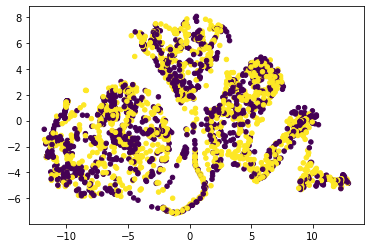

In [34]:
# t-sne例子
import pylab
X = data_trans(supervised_data[:2500])
from sklearn import datasets
from openTSNE import TSNEEmbedding
from openTSNE import TSNE
from openTSNE.affinity import PerplexityBasedNN
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

import numpy as np
import matplotlib.pyplot as plt
iris = datasets.load_iris()

tsne = TSNE(
    perplexity=30,
    n_iter=50,
    metric="euclidean",
    callbacks=ErrorLogger(),
    n_jobs=8,
    random_state=42,
)
embedding = tsne.fit(X)
Y = np.array(embedding)
pylab.scatter(Y[:, 0], Y[:, 1], 20, labels[:2500])
pylab.show()

## CNN训练

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

## 贝叶斯优化神经网络超参数
我们通过ax来实现贝叶斯优化，首先我们导入用到的函数

In [ ]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

下面我们构建一个训练网络的函数

In [ ]:
def net_train(net, train_loader, parameters, dtype, device):
    
    net.to(dtype=dtype, device=device)
 
 
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
  )
 
 
    scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
  )
 
 
    num_epochs = parameters.get("num_epochs", 30) # Play around with epoch number
    # Train Network
    for _ in range(num_epochs):
        for inputs, labels in train_loader:
            # move data to proper dtype and device
            inputs = inputs.to(dtype=dtype, device=device)
            labels = labels.to(device=device,dtype=torch.long)
 
 
            # zero the parameter gradients
            optimizer.zero_grad()
 
     
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
    return net

编写一个init_*()函数，该函数初始化模型并返回准备训练的网络

In [ ]:
# 初始化网络模型
in_channel = input_size = 10
def init_cnn(parameterization):
    model = cnn(in_channel=in_channel,out_channel=parameterization.get('out_channels',16),kernel_size=parameterization.get('kernel_size',3))
    return model

def init_lstm(parameterization):
    model = lstm(input_size=input_size,hidden_size=parameterization.get('hidden_size',16),lstm_layers=2,output_size=1,dropout=parameterization.get('dropout',0.1))
    return model

def init_lcp(parameterization):
    model = lstm_cnn_parallel(in_channel=in_channel,out_channel=parameterization.get('out_channels',16),hidden_size=parameterization.get('hidden_size',16),kernel_size=parameterization.get('kernel_size',2),lstm_layers=2,dropout=parameterization.get('dropout',0.1))
    return model

def init_lcs(parameterization):
    model = lstm_cnn_series(in_channel=in_channel,out_channel=parameterization.get('out_channels',16),kernel_size=parameterization.get('kernel_size',3)lstm_layers=2,dropout=parameterization.get('dropout',0.1))
    return model

我们需要一个train_evaluate_*()函数，该函数在每次运行时都会被贝叶斯优化器调用。 优化器在parameterization化中生成一组新的超parameterization ，将其传递给此函数，然后分析返回的评估结果。

In [ ]:
def train_evaluate_cnn(parameterization):
 
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(trainset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_cnn(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=testloader,
        dtype=dtype,
        device=device,
    )

In [ ]:
def train_evaluate_lstm(parameterization):
 
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(trainset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_lstm(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=testloader,
        dtype=dtype,
        device=device,
    )

In [ ]:
def train_evaluate_lcs(parameterization):
 
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(trainset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_lcs(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=testloader,
        dtype=dtype,
        device=device,
    )

In [ ]:
def train_evaluate_lcp(parameterization):
 
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(trainset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_lcp(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=testloader,
        dtype=dtype,
        device=device,
    )

### CNN优化
只需指定要扫描的超参数并将其传递给Ax的optimize()函数即可

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_best_parameters, cnn_values, cnn_experiment, cnn_model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "num_epochs", "type": "range", "bounds": [50, 200]},
        {"name": "step_size", "type": "range", "bounds": [20, 40]},
        {"name": "out_channels", "type": "range", "bounds": [16, 64]},
        {"name": "kernel_size", "type": "range", "bounds": [2, 6]},
        {"name": "gamma", "type": "range", "bounds": [0.9, 1]},
    ],
  
    evaluation_function=train_evaluate_cnn,
    objective_name='accuracy',
)
 
print(cnn_best_parameters)
cnn_means, cnn_covariances = cnn_values
print(cnn_means)
print(cnn_covariances)

### LSTM优化

In [ ]:
lstm_best_parameters, lstm_values, lstm_experiment, lstm_model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "num_epochs", "type": "range", "bounds": [50, 200]},
        {"name": "step_size", "type": "range", "bounds": [20, 40]},
        {"name": "hidden_size", "type": "range", "bounds": [16, 64]},
        {"name": "gamma", "type": "range", "bounds": [0.9, 1]},
        {"name": "dropout", "type": "range", "bounds": [0.1, 0.5]},
    ],
  
    evaluation_function=train_evaluate_lstm,
    objective_name='accuracy',
)
 
print(lstm_best_parameters)
lstm_means, lstm_covariances = lstm_values
print(lstm_means)
print(lstm_covariances)

### lcp优化

In [ ]:
lcp_best_parameters, lcp_values, lcp_experiment, lcp_model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "num_epochs", "type": "range", "bounds": [50, 200]},
        {"name": "step_size", "type": "range", "bounds": [20, 40]},
        {"name": "out_channels", "type": "range", "bounds": [16, 64]},
        {"name": "hidden_size", "type": "range", "bounds": [16, 64]},
        {"name": "kernel_size", "type": "range", "bounds": [2, 6]},
        {"name": "gamma", "type": "range", "bounds": [0.9, 1]},
        {"name": "dropout", "type": "range", "bounds": [0.1, 0.5]},
    ],
  
    evaluation_function=train_evaluate_lcp,
    objective_name='accuracy',
)

print(lcp_best_parameters)
lcp_means, lcp_covariances = lcp_values
print(lcp_means)
print(lcp_covariances)

### lcs优化

In [ ]:
lcs_best_parameters, lcs_values, lcs_experiment, lcs_model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "num_epochs", "type": "range", "bounds": [50, 200]},
        {"name": "step_size", "type": "range", "bounds": [20, 40]},
        {"name": "out_channels", "type": "range", "bounds": [16, 64]},
        {"name": "kernel_size", "type": "range", "bounds": [2, 6]},
        {"name": "gamma", "type": "range", "bounds": [0.9, 1]},
        {"name": "dropout", "type": "range", "bounds": [0.1, 0.5]},
    ],
  
    evaluation_function=train_evaluate_lcs,
    objective_name='accuracy',
)

print(lcs_best_parameters)
lcs_means, lcs_covariances = values
print(lcs_means)
print(lcs_covariances)

绘制一些图，这些图显示每个时期的精度(随着参数化的改进而提高)，以及优化器根据等高线图得出的两个超参数的函数所估计的精度。

In [ ]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
 
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)
 
render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [ ]:
#验证一下上面的方法
X = torch.randn(1000,10,10)
Y = torch.randint(high=2,size=(1000,))

## 使用AUC来可视化预测结果

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc(net):
    predict_result = net.predict().reshape()
    fpr,tpr,thresholds = roc_curve(test[:,3],predict_result,pos_label=1)
    plt.plot(fpr,tpr,linewidth=2,label='ROC of LM')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.show()